In [5]:
using MatrixNetworks
using Distributions
using Clustering
using NPZ
using BenchmarkTools, Compat
using DelimitedFiles
using SparseArrays
using Printf
using LinearAlgebra
using Plots
using SphericalGraphEmbedding
using LaTeXStrings

### Compute NMI between the retrieved and the true community


========== Graph 1/10 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------
The iteration has become stationary after 200 iterations
  1.716590 seconds (5.57 k allocations: 1.354 GiB, 17.73% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 100
Number of updates: 7
Number of communities: 41
Modularity: 900.6924062893414
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.3987657341492378, 0.26502291221156105, 0.17758294131036706, 0.09927587677727243, 0.057788953867704725]
 -------------------------------------------- 
 12.890263 seconds (1.98 M allocations: 3.549 GiB, 4.75% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------
The iteration has become stationary after 321 iterations
  2.354684 seconds (8.84 k allocations: 2.177 GiB, 10.70% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 1

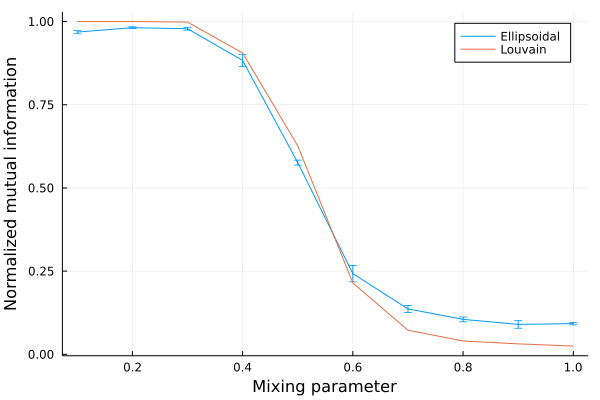

In [6]:
## Compute NMI for each graph
path = "LFR_data/"
n_graphs = 10

# Set parameters of simulations

n_it_PPM = 30000;
t = 1e-10;
n_clusters = 100;
d0 = 100;

# Specify here the number of times vector partition is repeated
n_it_Vec_Partition = 100;
n_updates = 100; # max total by default
shape = "Ellipsoidal"; #shape = "Spherical"

n_rep = 3;
mus=zeros(Float64,n_graphs)
NMIs=zeros(Float64,n_graphs,n_rep)
NMIs_louvain=zeros(Float64,n_graphs)

for g=1:n_graphs
    println("\n========== Graph $g/$(n_graphs) ==========")
    
    # load communities
    community_true = readdlm(path*"communities"*string(g-1)*".txt",Int)
    community_louvain = readdlm(path*"louvain_communities"*string(g-1)*".txt",Int)

    # load graph
    edgeList = readdlm(path*"edgeList"*string(g-1)*".txt",Int)

    n_nodes = size(community_true)[1]
    n_edges = size(edgeList)[1]

    # construct sparse adjacency matrix from list of edges
    adj = sparse(edgeList[:,1].+1,edgeList[:,2].+1,vec(ones(Int64,n_edges,1)),n_nodes,n_nodes)
    adj = adj+adj' 
    # only the upper triangular part of adjacency matrix was stored

    # keep only the largest connected component
    adj,vertices = largest_component(adj);
    
    community_true = community_true[vertices]
    community_true = rename_com_unique(community_true)
    
    community_louvain = community_louvain[vertices]
    community_louvain = rename_com_unique(community_louvain)

    # load parameters
    LFR_parameters = readdlm(path*"parameters"*string(g-1)*".txt")
    mu = parse(Float64, split(LFR_parameters[4],"=")[2]) 
    # extract mixing marameter (not very robust)
    mus[g] = mu
    
    for j=1:n_rep
        println("\n  ~~~~~ number_rep = $j/$(n_rep) ~~~~~")
        
         _,community,_ = @time sphere_embed_cluster(adj,n_it_PPM,t, n_clusters,n_it_Vec_Partition,n_updates,shape,d0)

        NMIs[g,j] = mutualinfo(community_true,community);
    end
    NMIs_louvain[g] = mutualinfo(community_true,community_louvain);
end

# Plot Normalized mutual information vs Miwing parameter

m = mean(NMIs,dims=2);
s = std(NMIs,dims=2);
plot(mus, m, yerror = s,
markerstrokecolor=:auto,
xlabel = "Mixing parameter",
ylabel = "Normalized mutual information",
labels = "Ellipsoidal")

plot!(mus, NMIs_louvain,
markerstrokecolor=:auto,
xlabel = "Mixing parameter",
ylabel = "Normalized mutual information",
labels = "Louvain")
savefig("figures/nmi_vs_mu.pdf")
plot!()


### Estimating the impact of $d_0$ on embedding quality

mu=0.4
========== d0 step 1/19 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------
The iteration has become stationary after 305 iterations
  0.311335 seconds (8.10 k allocations: 214.209 MiB, 12.02% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 10
Number of updates: 8
Number of communities: 12
Modularity: 492.0804158461796
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22008773356076342, 0.2128224310037121, 0.1810190436434928, 0.12806993552963372, 0.09918257046982744]
 -------------------------------------------- 
  2.806314 seconds (2.08 M allocations: 1.452 GiB, 5.45% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------
The iteration has become stationary after 319 iterations
  0.313873 seconds (8.46 k allocations: 224.065 MiB, 10.13% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clus

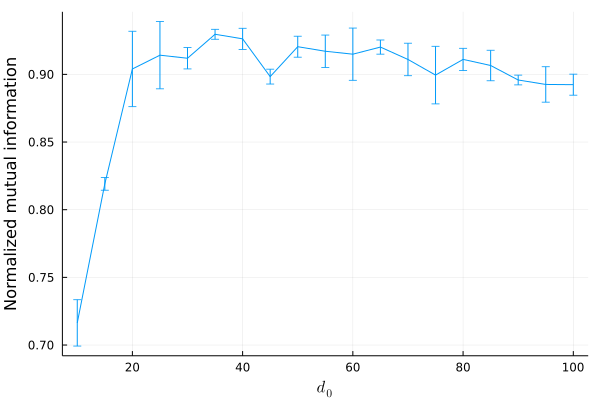

In [7]:
g = 4

# Set parameters of simulations
n_it_PPM = 30000;
t = 1e-10;
n_clusters = 100;
d0s = 10:5:100;

# Specify here the number of times vector partition is repeated
n_it_Vec_Partition = 100;

n_updates = 100; # max total by default
shape = "Ellipsoidal"; #shape = "Spherical"

n_rep = 3;
NMIs=zeros(Float64,length(d0s),n_rep)

# load communities
community_true = readdlm(path*"communities"*string(g-1)*".txt",Int)

# load graph
edgeList = readdlm(path*"edgeList"*string(g-1)*".txt",Int)

n_nodes = size(community_true)[1]
n_edges = size(edgeList)[1]

# construct sparse adjacency matrix from list of edges
adj = sparse(edgeList[:,1].+1,edgeList[:,2].+1,vec(ones(Int64,n_edges,1)),n_nodes,n_nodes)
adj = adj+adj' # only the upper triangular part of adjacency matrix was stored

# keep only the largest connected component
adj,vertices = largest_component(adj);

community_true = community_true[vertices]
community_true = rename_com_unique(community_true)

# load parameters
LFR_parameters = readdlm(path*"parameters"*string(g-1)*".txt")
mu = parse(Float64, split(LFR_parameters[4],"=")[2]) # extract mixing marameter (not very robust)
print("mu=$mu")

for i=1:length(d0s)
    println("\n========== d0 step $i/$(length(d0s)) ==========")
    d0=d0s[i]
    for j=1:n_rep
        println("\n  ~~~~~ number_rep = $j/$(n_rep) ~~~~~")
        
        _,community,_ = @time sphere_embed_cluster(adj,n_it_PPM,t, n_clusters,n_it_Vec_Partition,n_updates,shape,d0)

        NMIs[i,j] = mutualinfo(community_true,community);
    end
end


# Plot Normalized mutual information vs d0
m = mean(NMIs,dims=2);
s = std(NMIs,dims=2);
plot(d0s, m, yerror = s,
markerstrokecolor=:auto,
xlabel = L"d_0",
ylabel = "Normalized mutual information",
legend = false)

savefig("figures/nmi_vs_d0__mu"*string(mu)*".pdf")
plot!()


### Test impact of n_clusters

mu=0.4
========== n_clusters step 1/10 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------
The iteration has become stationary after 233 iterations
  3.319094 seconds (6.46 k allocations: 1.578 GiB, 12.31% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 100
Number of updates: 12
Number of communities: 10
Modularity: 676.7407617441856
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22012468904062255, 0.2131551803233585, 0.18103817519490878, 0.12812779180123954, 0.09908855835673347]
 -------------------------------------------- 
  7.828702 seconds (2.99 M allocations: 3.231 GiB, 9.49% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------
The iteration has become stationary after 232 iterations
  2.639080 seconds (6.43 k allocations: 1.572 GiB, 9.73% gc time)
 -------------- Clustering ------- 
dimension of embedding used fo

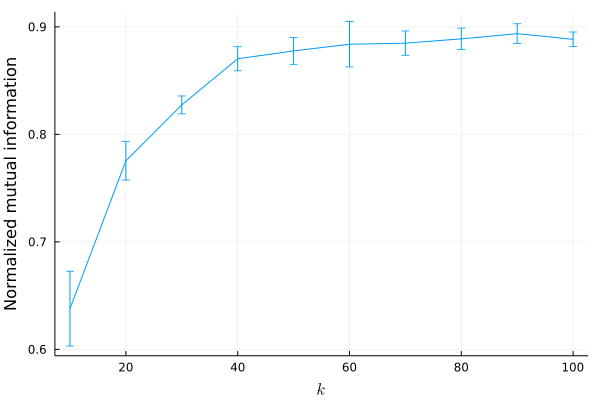

In [8]:
g = 4

# Set parameters of simulations
n_it_PPM = 30000;
t = 1e-10;
n_clusters_list = 10:10:100;
d0 = 100;

# Specify here the number of times vector partition is repeated
n_it_Vec_Partition = 100;
# we advise : n_it_Vec_Partition = 100;

n_updates = 100; # max total by default
shape = "Ellipsoidal"; #shape = "Spherical"

n_rep = 3;
NMIs=zeros(Float64,length(n_clusters_list),n_rep)

# load communities
community_true = readdlm(path*"communities"*string(g-1)*".txt",Int)

# load graph
edgeList = readdlm(path*"edgeList"*string(g-1)*".txt",Int)

n_nodes = size(community_true)[1]
n_edges = size(edgeList)[1]

# construct sparse adjacency matrix from list of edges
adj = sparse(edgeList[:,1].+1,edgeList[:,2].+1,vec(ones(Int64,n_edges,1)),n_nodes,n_nodes)
adj = adj+adj' # only the upper triangular part of adjacency matrix was stored

# keep only the largest connected component
adj,vertices = largest_component(adj);

community_true = community_true[vertices]
community_true = rename_com_unique(community_true)

# load parameters
LFR_parameters = readdlm(path*"parameters"*string(g-1)*".txt")
mu = parse(Float64, split(LFR_parameters[4],"=")[2]) # extract mixing marameter (not very robust)
print("mu=$mu")

for i=1:length(n_clusters_list)
    println("\n========== n_clusters step $i/$(length(n_clusters_list)) ==========")
    n_clusters = n_clusters_list[i]
    for j=1:n_rep
        println("\n  ~~~~~ number_rep = $j/$(n_rep) ~~~~~")

        # embed cluster
        _,community,_ = @time sphere_embed_cluster(adj,n_it_PPM,t, n_clusters,n_it_Vec_Partition,n_updates,shape,d0)

        NMIs[i,j] = mutualinfo(community_true,community);
    end
end

# Plot Normalized mutual information vs d0
m = mean(NMIs,dims=2);
s = std(NMIs,dims=2);
plot(n_clusters_list, m, yerror = s,
markerstrokecolor=:auto,
xlabel = L"k",
ylabel = "Normalized mutual information",
legend = false)

savefig("figures/nmi_vs_nclusters__mu"*string(mu)*".pdf")
plot!()
